# Book Recommendation System

## Load Data

Tahap awal yang harus dilakukan adalah mendownload data dari kaggle

In [84]:
!kaggle datasets download -d arashnic/book-recommendation-dataset --unzip -p book-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
 90% 22.0M/24.3M [00:01<00:00, 31.9MB/s]
100% 24.3M/24.3M [00:01<00:00, 21.2MB/s]


## Library

Tahap selanjutnya melakukan import library yang diperlukan seperti berikut:

*   **numpy** : Digunakan untuk operasi numerik, seperti perhitungan vektor dan matriks.
*   **pandas** : Digunakan untuk manipulasi dan analisis data berbasis tabel.
*   **matplotlib** : Digunakan Untuk visualisasi data, seperti membuat grafik.
*   **TruncatedSVD** : Digunakan Untuk reduksi dimensi matriks sparse.
*   **csr_matrix** : Digunakan untuk merepresentasikan matriks dalam format sparse guna menghemat memori ketika bekerja dengan dataset besar yang memiliki banyak nilai nol
, seperti matriks rating.
*   **cosine_similarity** : Digunakan untuk menghitung kesamaan antar-vektor.
*   **TfidfVectorizer** : Digunakan untuk mengonversi teks menjadi representasi numerik menggunakan metode TF-IDF.
*   **warnings** : Digunakan untuk mengontrol pesan warning, seperti menyembunyikan pesan warning.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

Pada tahap ini dilakukan eksplorasi pada dataset guna mengetahui lebih lanjut karakteristik dataset seeprti jumlah, tipe data, isi data, dll.

In [86]:
books = pd.read_csv('/content/book-recommendation-dataset/Books.csv')
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [87]:
ratings = pd.read_csv('/content/book-recommendation-dataset/Ratings.csv')
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [88]:
users = pd.read_csv('/content/book-recommendation-dataset/Users.csv')
users.head(2)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [89]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [90]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [91]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Berdasarkan eksplorasi diatas, data memiliki beragam tipe data seperti object, integer, dan float. Tahap selanjutnya adalah memilih feature penting yang akan digunakan. Pada data buku hanya akan menggunakan ISBN, judul, dan nama author. Sedangkan pada data user akan menggunakan id dan lokasi.

In [92]:
# pilih feature yang akan digunakan

books = books[['ISBN', 'Book-Title', 'Book-Author']]
users = users[['User-ID', 'Location']]

Selanjutnya melakukan rename agar feature menjadi lebih mudah dibaca.

In [93]:
# rename feature

ratings = ratings.rename(columns={'User-ID': 'User', 'Book-Rating': 'Rating'})
users = users.rename(columns={'User-ID': 'User'})
books = books.rename(columns={'Book-Title': 'Title', 'Book-Author': 'Author'})

Pada feature lokasi, akan digunakan data nama negara saja karena akan lebih mengelompokkan lokasi asal pembaca/user dengan lebih baik.

In [94]:
# split location

users['Location'] = users['Location'].str.split(',').str[-1].str.strip()
users.head(2)

,User,Location
0,1,usa
1,2,usa


Berikut dapat dilihat jumlah data pada setiap dataframe. Data tersebut sangat banyak, data buku dan user lebih dari 270 ribu sedangkan rating lebih dari 1 juta.

In [95]:
# lihat data tiap df

print('jumlah data books: ', books.shape)
print('jumlah data ratings: ',ratings.shape)
print('jumlah data users: ',users.shape)

jumlah data books:  (271360, 3)
jumlah data ratings:  (1149780, 3)
jumlah data users:  (278858, 2)


Proses selanjutnya adalah memeriksa missing value pada tiap dataframe. Karena missing value tidak banyak dan hanya ada di buku maka dihapus saja.

In [96]:
# Check for missing values in each DataFrame

print("Missing values in books DataFrame:\n", books.isnull().sum())
print("\nMissing values in ratings DataFrame:\n", ratings.isnull().sum())
print("\nMissing values in users DataFrame:\n", users.isnull().sum())

Missing values in books DataFrame:
 ISBN      0
Title     0
Author    2
dtype: int64

Missing values in ratings DataFrame:
 User      0
ISBN      0
Rating    0
dtype: int64

Missing values in users DataFrame:
 User        0
Location    0
dtype: int64


In [97]:
# drop missing value

books.dropna(inplace=True)

Karena memerlukan feature pada dataframe buku dan ratings, maka merge data dilakukan berdasarkan ISBN.

In [98]:
# merge data ratings dan books

ratings_books_titles = ratings.merge(books,on='ISBN')

In [99]:
ratings_books_titles.head(2)

,User,ISBN,Rating,Title,Author
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose
1,276726,0155061224,5,Rites of Passage,Judith Rae


Memeriksa apakah ada missing value, duplicate, dan ukuran data yang telah di merge.

In [100]:
print("Missing values in ratings_books_titles DataFrame:\n", ratings_books_titles.isnull().sum(),"\n")
print("Duplicated in ratings_books_titles DataFrame: ", ratings_books_titles.duplicated().sum(),"\n")
print("shape in ratings_books_titles DataFrame: ", ratings_books_titles.shape)

Missing values in ratings_books_titles DataFrame:
 User      0
ISBN      0
Rating    0
Title     0
Author    0
dtype: int64 

Duplicated in ratings_books_titles DataFrame:  0 

shape in ratings_books_titles DataFrame:  (1031134, 5)


Melakukan identifikasi mengenai jumlah judul buku, jumlah pembaca, dan lokasi pembaca.

In [101]:
#identifikasi jumlah

print('Jumlah judul buku: ', len(ratings_books_titles.ISBN.unique()))
print('Jumlah pembaca: ', len(ratings_books_titles.User.unique()))
print('Jumlah lokasi pembaca: ', len(users.Location.unique()))

Jumlah judul buku:  270149
Jumlah pembaca:  92106
Jumlah lokasi pembaca:  709


Melakukan visualisasi untuk melihat buku apa yang paling populer di antara user. Buku dipilih berdasarkan yang paling banyak diberi rating oleh user. Hasilnya didapatkan bahwa buku berjudul Wild Animus adalah yang paling populer.

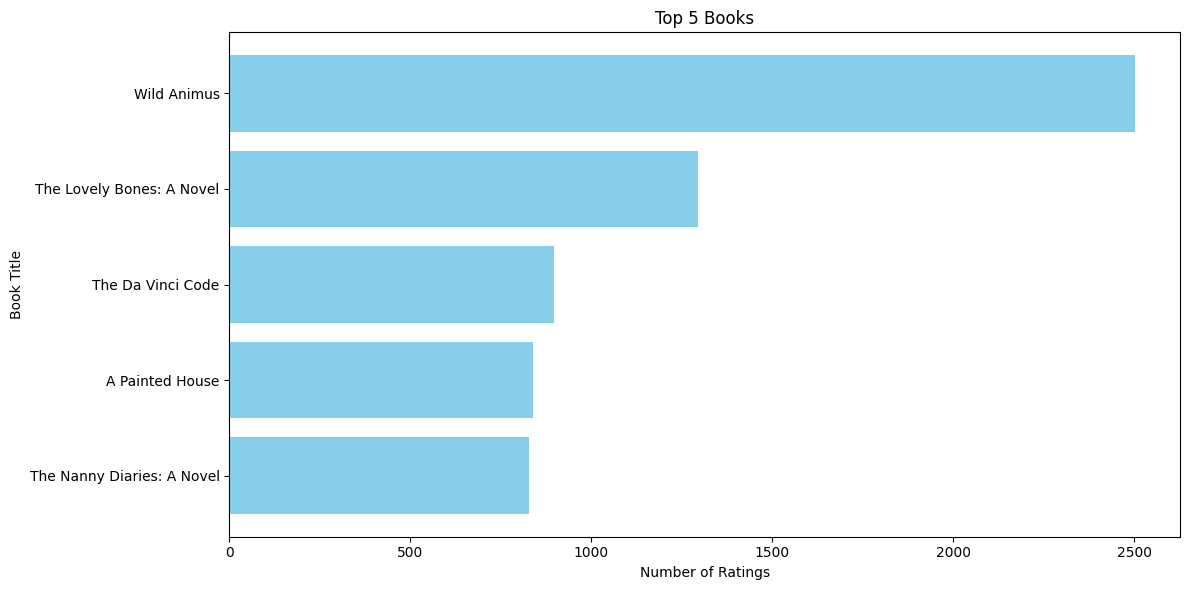

In [102]:
# Group by book title dan hitung jumlah ratings
popular_books = ratings_books_titles.groupby('Title')['Rating'].count().reset_index()

# Sort by rating count dalam descending order
top_5_books = popular_books.sort_values('Rating', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(top_5_books['Title'], top_5_books['Rating'], color='skyblue')
plt.xlabel("Number of Ratings")
plt.ylabel("Book Title")
plt.title("Top 5 Books")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Visualisasi untuk melihat lokasi dengan user paling banyak. Hasilnya menunjukkan bahwa usa merupakan lokasi dengan user atau pembaca terbanyak.

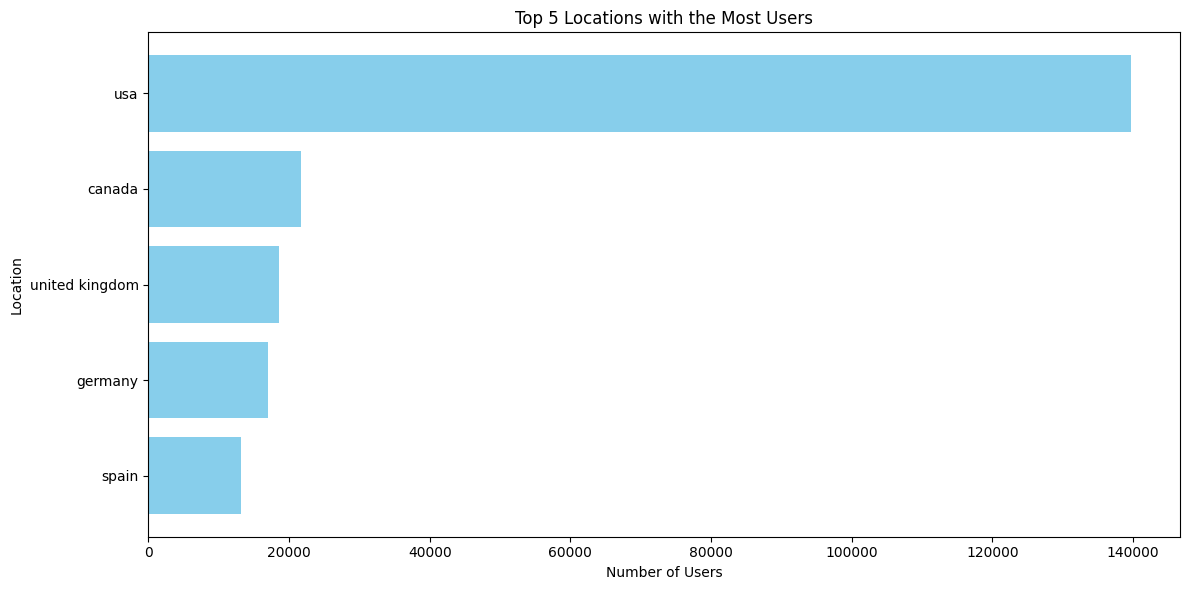

In [103]:
# Group by location dan count number users
location_counts = users.groupby('Location')['User'].count().reset_index()

# Sort by user count dalam descending order
top_5_locations = location_counts.sort_values('User', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(top_5_locations['Location'], top_5_locations['User'], color='skyblue')
plt.xlabel("Number of Users")
plt.ylabel("Location")
plt.title("Top 5 Locations with the Most Users")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Data Preparation

Tahap ini dilakukan untuk mempersiapkan data agar dapat diproses pada tahap pembuatan model rekomendasi.

### Preparation Collaborative Filtering

Karena data yang terlalu banyak maka hanya akan menggunakan sample yang mewakili keseluruhan data, agar proses komputasi tidak berat. Data yang akan digunakan untuk Collaborative Filtering akan di filter dengan ketentuan seperti berikut:

*   Data user yang telah memberi rating lebih dari 100 buku.
*   Data buku yang telah diberi rating lebih dari 200 kali.



In [104]:
# Filter user yang telah memberi rating lebih dari 100 buku
user_rating_counts = ratings_books_titles.groupby('User')['Rating'].count()
active_users = user_rating_counts[user_rating_counts > 100].index

# Filter buku yang telah diberi rating lebih dari 200 kali
book_rating_counts = ratings_books_titles.groupby('ISBN')['Rating'].count()
popular_books = book_rating_counts[book_rating_counts > 200].index

# Filter rating
filtered_CF = ratings_books_titles[
    ratings_books_titles['User'].isin(active_users) &
    ratings_books_titles['ISBN'].isin(popular_books)
]

print(filtered_CF.shape)

(27841, 5)


Selanjutnya membangun matriks yang akan digunakan pada model SVD untuk Collaborative Filtering.

In [105]:
utility_matrix_filtered = filtered_CF.pivot_table(
    index='User', columns='Title', values='Rating'
).fillna(0).T

print(f"Sparse Matrix Shape: {utility_matrix_filtered.shape}")

Sparse Matrix Shape: (190, 1578)


In [106]:
utility_matrix_filtered.head(5)

User,254,507,882,1424,1435,1733,1903,2033,2110,2276,...,275020,275970,276463,276680,277427,277478,277639,278137,278188,278418
Title,,,,,,,,,,,,,,,,,,,,,
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A Child Called \It\"": One Child's Courage to Survive""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Heartbreaking Work of Staggering Genius,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


konversi utility matriks menjadi sparse matriks, sparse matrix hanya menyimpan nilai non-nol, sehingga lebih hemat memori dan efisien untuk dataset yang besar dan jarang terisi.

In [107]:
# Ubah matriks menjadi sparse matrix
sparse_utility_matrix = csr_matrix(utility_matrix_filtered.values)

### Preparation Content-Based Filtering

Untuk pendekatan Content-Based Filtering akan digunakan 1000 sample data dari dataframe books, data yang digunakan ialah data author yang telah menulis lebih dari 1 buku.

In [108]:
books_list = books.copy()

In [109]:
author_counts = books.groupby('Author')['ISBN'].count()
authors_more_than_one_book = author_counts[author_counts > 2].index
books_list = books[books['Author'].isin(authors_more_than_one_book)]
books_list.head()

,ISBN,Title,Author
2,0060973129,Decision in Normandy,Carlo D'Este
5,0399135782,The Kitchen God's Wife,Amy Tan
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley
7,0671870432,PLEADING GUILTY,Scott Turow
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly


In [110]:
filtered_CBF = books_list.head(1000)
filtered_CBF.shape

(1000, 3)

Selanjutnya melakukan ekstraksi fitur menggunakan TF-IDF Vectorizer, dengan menghitung nilai TF-IDF Author

In [111]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data author
tf.fit(filtered_CBF['Author'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['aarsen', 'abraham', 'abrahams', ..., 'zola', 'zukav', 'âºlveda'],
      dtype=object)

Langkah ini mengubah data teks Author menjadi bentuk numerik berupa matriks TF-IDF. Matriks ini digunakan untuk merepresentasikan Author dalam ruang fitur berdasarkan kata-kata unik, sehingga dapat digunakan dalam perhitungan kesamaan atau sebagai input untuk algoritma lain.

In [112]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(filtered_CBF['Author'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(1000, 1017)

Selanjutnya mengonversi data teks pada kolom Author menjadi matriks dense, yang merupakan representasi numerik dari teks yang akan menjadi dasar untuk mengukur kesamaan antar buku berdasarkan Author.

In [113]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Modelling

Pada tahap ini membuat model untuk sistem rekomendasi. SVD untuk Collaborative Filtering sedangkan Cosine Similarity untuk Content-Based Filtering.

## SVD untuk Collaborative Filtering

Pada proses ini terdapat beberapa tahapan penting seperti:
* menentukan jumlah fitur laten sebanyak 50 untuk mengurangi dimensi data.
* implementasi truncated SVD
* rekontruksi matriks kembali menggunakan hasil SVD

In [114]:
# Tentukan jumlah komponen yang ingin dipertahankan
n_components = 50

# Terapkan Truncated SVD
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(sparse_utility_matrix)

# Rekonstruksi matriks dari hasil SVD
reconstructed_matrix = np.dot(svd_matrix, svd.components_)

# Tampilkan dimensi matriks SVD dan rekonstruksi
print(f"Shape of SVD Matrix: {svd_matrix.shape}")
print(f"Shape of Reconstructed Matrix: {reconstructed_matrix.shape}")


Shape of SVD Matrix: (190, 50)
Shape of Reconstructed Matrix: (190, 1578)


Membuat fungsi untuk memberikan rekomendasi buku dengan pendekatan Collaborative Filtering. Rekomendasi dibuat berdasarkan id user dan akan mengurutkan 5 buku teratas.

In [115]:
def recommended_books_CF(user_id, utility_matrix, reconstructed_matrix, books_metadata, top_n=5):
    """
    Memberikan rekomendasi buku berdasarkan ID user.

    Args:
    user_id (int): ID user yang ingin diberi rekomendasi.
    utility_matrix (pd.DataFrame): Matriks utility (rating user terhadap buku).
    reconstructed_matrix (np.array): Matriks yang direkonstruksi setelah SVD.
    books_metadata (pd.DataFrame): DataFrame berisi metadata buku (Title, Author).
    top_n (int): Jumlah buku teratas yang akan direkomendasikan (default 5).

    Returns:
    pd.DataFrame: DataFrame dengan kolom Title, Author, dan Predicted Rating.
    """
    # Ambil indeks user di matriks
    user_index = utility_matrix.columns.get_loc(user_id)

    # Prediksi rating untuk semua buku yang belum dinilai oleh user
    predicted_ratings = reconstructed_matrix[:, user_index]

    # Ambil buku dengan rating prediksi tertinggi (buku yang belum diberi rating)
    unrated_books = utility_matrix.index[utility_matrix.loc[:, user_id] == 0]
    predicted_ratings_for_unrated = [(book, predicted_ratings[utility_matrix.index.get_loc(book)])
                                     for book in unrated_books]

    # Urutkan berdasarkan prediksi rating tertinggi
    predicted_ratings_for_unrated.sort(key=lambda x: x[1], reverse=True)

    # Ambil top_n buku teratas
    top_recommended_books = predicted_ratings_for_unrated[:top_n]

    # Gabungkan dengan metadata buku
    recommendations_df = pd.DataFrame(top_recommended_books, columns=['Title', 'Predicted Rating'])
    recommendations_df = recommendations_df.merge(books_metadata, on='Title', how='left')

    # Pilih hanya kolom yang relevan
    recommendations_df = recommendations_df[['Title', 'Author', 'Predicted Rating']]

    return recommendations_df

# Metadata buku dengan kolom ISBN, Title, dan Author
books_metadata = books[['Title', 'Author']]

Memberikan rekomendasi untuk user 254

In [116]:
user_id = 254

top_recommended_CF = recommended_books_CF(user_id, utility_matrix_filtered, reconstructed_matrix, filtered_CF, top_n=5)

# drop duplicated untuk melihat 5 buku teratas
top_recommended_CF = top_recommended_CF.drop_duplicates()
top_recommended_CF

,Title,Author,Predicted Rating
0,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,2.631278
239,Neverwhere,Neil Gaiman,2.047738
335,Midnight in the Garden of Good and Evil: A Sav...,John Berendt,1.814748
446,White Oleander : A Novel,Janet Fitch,1.638716
560,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1.333225


## Cosine Similarity untuk Content-Based Filtering

Pada tahap ini menghitung cosine similarity pada matriks untuk melihat kemiripan antar buku

In [117]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [118]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=filtered_CBF['Title'], columns=filtered_CBF['Title'])

# Melihat similarity matrix
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Title,Of Love and Shadows,Flood : Mississippi 1927,Always Daddy's Girl: Understanding Your Father's Impact on Who You Are,Le Loup-garou,"The Ruby in the Smoke (Sally Lockhart Trilogy, Book 1)"
Title,,,,,
Cold Mountain (MTI) (Vintage Contemporaries),0.0,0.0,0.0,0.0,0.0
Pen Pals,0.0,0.0,0.0,0.0,0.0
"The First Journey (Animorphs. Alternamorphs, 1)",0.0,0.0,0.0,0.0,0.0
High Wizardry: The Third Book in the Young Wizards Series,0.0,0.0,0.0,0.0,0.0
Neanderthal: A Novel,0.0,0.0,0.0,0.0,0.0
Falling Leaves: The True Story of an Unwanted Chinese Daughter,0.0,0.0,0.0,0.0,0.0
Jane Doe,0.0,0.0,0.0,0.0,0.0
The Cove,0.0,0.0,0.0,0.0,0.0
Paroles de Poilus : Lettres et carnets du front 1914-1918,0.0,0.0,0.0,0.0,0.0


Setelah melakukan proses tersebut, fungsi untuk rekomendasi buku dengan pendekatan Content-Based Filtering dibuat. Fungsi akan memberi rekomendasi berdasarkan input judul buku dan mencari kemiripan berdasarkan Author.

In [119]:
def recommended_books_CBF(judul_buku, similarity_data=cosine_sim_df, items=filtered_CBF[['Title', 'Author']], k=5):
    """
    Rekomendasi buku berdasarkan kemiripan dataframe

    Parameter:
    ---
    judul_buku : tipe data string (str)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik,
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---

    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    index = similarity_data.loc[:,judul_buku].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop judul_buku agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(judul_buku, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Memberikan rekomendasi buku yang mirip Night Watch

In [120]:
title = 'Night Watch'

target_CBF = filtered_CBF[filtered_CBF.Title.eq(title)]
target_CBF

,ISBN,Title,Author
254,0060013117,Night Watch,Terry Pratchett


In [121]:
top_recommended_CBF = recommended_books_CBF(title)
top_recommended_CBF

,Title,Author
0,Interesting Times: A Novel of Discworld,Terry Pratchett
1,"Maskerade: A Novel of Discworld (Pratchett, Te...",Terry Pratchett
2,Moving Pictures (Discworld Novels (Paperback)),Terry Pratchett
3,Thief of Time,Terry Pratchett
4,Das Meer und kleine Fische.,Terry Pratchett


## Evaluasi

### Evaluasi SVD untuk Collaborative Filtering

Evaluasi dilakukan dengan menghitung precision. buku yang relevant diambil dari data buku yang telah diberi rating oleh user. Lalu hitung relevant_in_recommendations dengan jumlah buku yang sama antara relevant dengan recomended. Selanjutnya precision didapat dari total buku relevant_in_recommendations dibagi dengan total buku recommended.

In [122]:
# Definisikan threshold untuk menentukan buku yang relevan
relevance_threshold = 3

# Ambil ground truth buku relevan untuk pengguna
relevant_books_per_user = ratings_books_titles[ratings_books_titles['Rating'] >= relevance_threshold].groupby('User')['Title'].apply(set)

# Ambil buku yang direkomendasikan oleh model
recommended_books = set(top_recommended_CF['Title'])

# Ambil buku yang relevan untuk user
relevant_books = relevant_books_per_user.get(user_id, set())

# Hitung jumlah buku relevan di rekomendasi
relevant_in_recommendations = recommended_books.intersection(relevant_books)

# Precision: proporsi buku relevan di antara buku yang direkomendasikan
precision_CF = len(relevant_in_recommendations) / len(recommended_books) if recommended_books else 0


print(f"Precision {precision_CF:.2f}")


Precision 0.20


### Evaluasi Cosine Similarity untuk Content-Based Filtering

Evaluasi dilakukan dengan menghitung precision. Jumlah rekomendasi yang relevan (input) dibagi jumlah rekomendasi, dengan Author untuk melihat kemiripannya.

In [123]:
# ambil data author dari buku yang relevan (input) dan jadikan list
relevant_CBF = target_CBF['Author'].tolist()

# ambil data author dari buku yang direkomendasikan (input) dan jadikan list
recomended_CBF = top_recommended_CBF['Author'].tolist()

# hitung jumlah rekomendasi yang sesuai dengan relevan
relevant_recommendation_CBF = len(top_recommended_CBF[top_recommended_CBF['Author'] == relevant_CBF[0]])

# hitung precision
precision_CBF = relevant_recommendation_CBF / len(recomended_CBF) if len(recomended_CBF) > 0 else 0

print(f"Precision: {precision_CBF}")

Precision: 1.0
